In [19]:
import sys
import numpy as np
from pyDOE import lhs
import torch
from torch import Tensor, ones, stack, load
from torch.autograd import grad
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.pyplot import figure
import pandas as pd
from torch.nn import Module
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from scipy import stats
sys.path.insert(0,'/content/drive/MyDrive/NeuralSolvers-heat-eqn/examples/Research project')
from tesladatadiff4 import TeslaDatasetAll, TeslaDatasetSlice, TeslaDatasetpinn

sys.path.append("/content/drive/MyDrive/NeuralSolvers-heat-eqn") 
import PINNFramework as pf

In [20]:
# Use cuda if it is available, else use the cpu
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [21]:
def derivative(x, u):

    #u = u[:, 0]
    grads = ones(u.shape, device=u.device) # move to the same device as prediction
    grad_u = grad(u, x, create_graph=True, grad_outputs=grads )[0]
   
    # calculate first order derivatives
    #print('grad u', grad_u.shape)
    u_t = grad_u[:,:, 5]
    #u_t = grad_u[:, 1]
    #u_t = grad_u

    return u_t

In [22]:
normalize = 1
batch_size = 1

In [23]:
# Create instance of the dataset
#ds = TeslaDatasetAll(device = device, normalize = normalize,rel_time = True)
ds = TeslaDatasetpinn(device = device, normalize = normalize, rel_time = False, ID = -1)


(445266, 10)


In [24]:
train_loader = DataLoader(ds, batch_size=batch_size, shuffle=False)
#next(iter(train_loader))

In [25]:
model = pf.models.MLP(input_size=6,
                      output_size=1, 
                      hidden_size=100, 
                      num_hidden=4, 
                      lb=ds.lb, 
                      ub=ds.ub,
                      activation = torch.relu
                      )
model.to(device)


In [26]:
optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)
criterion = torch.nn.MSELoss()

Starting epoch 0
Loss after mini-batch    50: 92.37189856
Epoch  0 Total Loss  80.84571196716468
Epoch  0 Loss 1  5.1328349636877e-06
Epoch  0 Loss 2 80.8457071566625
Starting epoch 1
Loss after mini-batch    50: 42.21926469
Epoch  1 Total Loss  26.185339900046454
Epoch  1 Loss 1  7.709267126934452e-06
Epoch  1 Loss 2 26.185332378767658
Starting epoch 2
Loss after mini-batch    50: 15.85813421
Epoch  2 Total Loss  9.05240271877876
Epoch  2 Loss 1  9.161555269518871e-06
Epoch  2 Loss 2 9.052393511085855
Starting epoch 3
Loss after mini-batch    50: 4.30808794
Epoch  3 Total Loss  2.747796106589676
Epoch  3 Loss 1  9.715207546423296e-06
Epoch  3 Loss 2 2.7477863883338585
Starting epoch 4
Loss after mini-batch    50: 1.89175888
Epoch  4 Total Loss  1.3883622405095721
Epoch  4 Loss 1  1.0721866556849016e-05
Epoch  4 Loss 2 1.3883515168363558
Starting epoch 5
Loss after mini-batch    50: 0.81216931
Epoch  5 Total Loss  0.7610747073203763
Epoch  5 Loss 1  1.0928946401227705e-05
Epoch  5 Loss

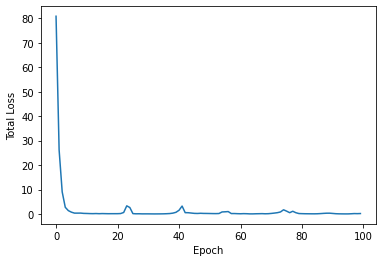

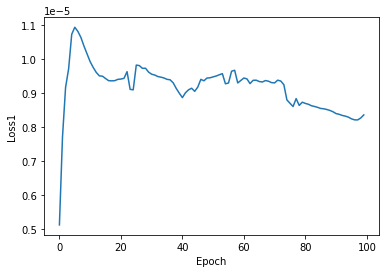

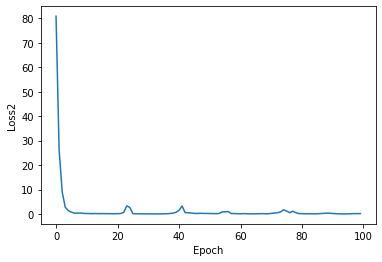

In [27]:
x_data_plot=[]
y_data_all_plot=[]
y_data_1_plot=[]
y_data_2_plot=[]

# Set fixed random number seed
torch.manual_seed(42)

Epochs = 100
for epoch in range(Epochs):
    # Print epoch
    print(f'Starting epoch {epoch}')
    
    # Set current and total loss value
    current_loss = 0.0
    total_loss = 0.0
    total_loss1 = 0.0
    total_loss2 = 0.0

    for i, data in enumerate(train_loader,0):
        #print(i)

        x_batch, y_batch, temp = data
        #print('x batch', x_batch.shape)
        #print('y batch', y_batch.shape)
        #print('temp', temp.shape)
        #print('x batch', x_batch)

        optimizer.zero_grad()
        #print('x batch0', x_batch.shape)
        #x_batch.requires_grad=True
        x0 = x_batch[:,0,:]
        x =  x_batch[:,1:,:]
        #print('x',x)
        #print('x0',x0)
        x.requires_grad=True
        u_pred = model(x.to(device))
        #print('u_pred :', u_pred)
        #print(' x batch 0', x_batch)
        u_t = derivative(x,u_pred)*normalize
        #print('u t', u_t.shape)

        initial = model(x0.to(device))
        #print('y batch', y_batch.shape)
        #print('y_batch[:,1:,:]', y_batch[:,1:,:])
        loss1 = criterion(u_t.reshape(-1).to(device),y_batch[:,1:,:].reshape(-1).to(device))
        loss2 = criterion(initial.to(device),temp[:,0, :].to(device))
        loss = loss1+loss2

        loss.backward()
        optimizer.step()

        # Print statistics
        current_loss += loss.item()
        total_loss += loss.item()
        total_loss1 += loss1.item()
        total_loss2 += loss2.item()

        if i % 50 == 49:
            print('Loss after mini-batch %5d: %.8f' %
                  (i + 1, current_loss / 50))
            current_loss = 0.0

    print("Epoch ", epoch, "Total Loss ", total_loss/(i+1))
    print("Epoch ", epoch, "Loss 1 ", total_loss1/(i+1))
    print("Epoch ", epoch, "Loss 2", total_loss2/(i+1))

    x_data_plot.append(epoch)
    y_data_all_plot.append(total_loss/(i+1))
    y_data_1_plot.append(total_loss1/(i+1))
    y_data_2_plot.append(total_loss2/(i+1))

# Make the plot of Total Loss vs epochs
plt.plot(x_data_plot,y_data_all_plot)
plt.xlabel('Epoch')
plt.ylabel('Total Loss')
plt.show()

# Make the plot of the supervised loss
plt.plot(x_data_plot,y_data_1_plot)
plt.xlabel('Epoch')
plt.ylabel('Loss1')
plt.show()

# Make the plot of time stability loss
plt.plot(x_data_plot,y_data_2_plot)
plt.xlabel('Epoch')
plt.ylabel('Loss2')
plt.show()

In [28]:
initial

tensor([[17.7277]], grad_fn=<AddmmBackward>)

In [29]:
temp[0]

tensor([[18.5600],
        [18.5600],
        [18.5600],
        [18.5600],
        [18.5600],
        [18.5600],
        [18.5600],
        [18.5600],
        [18.5600],
        [18.5600],
        [18.5600],
        [18.5600],
        [18.5600],
        [18.5600],
        [18.5600],
        [18.5600],
        [18.5600],
        [18.5600],
        [18.5600],
        [18.5600],
        [18.5600],
        [18.5600],
        [18.5600],
        [18.5600],
        [18.5600],
        [18.5600],
        [18.5600],
        [18.5600],
        [18.5600],
        [18.5600],
        [18.5600],
        [18.5600],
        [18.5600],
        [18.5600],
        [18.5600],
        [18.5599],
        [18.5598],
        [18.5598],
        [18.5596],
        [18.5593],
        [18.5592],
        [18.5591],
        [18.5591],
        [18.5591],
        [18.5590],
        [18.5590],
        [18.5590],
        [18.5589],
        [18.5588],
        [18.5586],
        [18.5585],
        [18.5585],
        [18.

In [30]:
u_t.shape

torch.Size([1, 201])

In [31]:
y_batch[:,1:,:].shape

torch.Size([1, 201, 1])

In [32]:
y_batch.shape

torch.Size([1, 202, 1])

In [33]:
u_pred

tensor([[[17.7285],
         [17.7038],
         [17.6897],
         [17.6751],
         [17.6613],
         [17.6476],
         [17.6219],
         [17.6089],
         [17.6207],
         [17.6075],
         [17.6050],
         [17.6025],
         [17.6138],
         [17.5999],
         [17.5854],
         [17.5848],
         [17.5969],
         [17.6089],
         [17.6075],
         [17.5935],
         [17.5797],
         [17.5916],
         [17.5776],
         [17.5770],
         [17.5639],
         [17.5508],
         [17.5376],
         [17.5497],
         [17.5616],
         [17.5736],
         [17.5855],
         [17.5975],
         [17.6094],
         [17.5961],
         [17.5820],
         [17.5805],
         [17.5792],
         [17.5765],
         [17.5585],
         [17.5446],
         [17.5441],
         [17.5434],
         [17.5430],
         [17.5428],
         [17.5547],
         [17.5666],
         [17.5660],
         [17.5633],
         [17.5480],
         [17.5347],


In [34]:
ds.temp

tensor([[12.9466],
        [12.9493],
        [12.9520],
        ...,
        [18.5494],
        [18.5494],
        [18.5493]])

In [35]:
# Some statistics on the model performance on all of dataset
mae = np.sum(np.abs(u_t.detach().numpy() - y_batch[:,1:,:].detach().numpy() ).mean(axis=None))
print('MAE:', mae)

mse = ((u_t.detach().numpy() - y_batch[:,1:,:].detach().numpy())**2).mean(axis=None)
print('MSE:', mse)

rel_error = np.linalg.norm(u_t.detach().numpy() - y_batch[:,1:,:].detach().numpy()) / np.linalg.norm(y_batch[:,1:,:].detach().numpy())
print('Relative error (%):', rel_error*100)

MAE: 0.0023918557
MSE: 5.724791e-06


NameError: ignored

In [ ]:
#torch.save(model.state_dict(),  '/content/drive/MyDrive/NeuralSolvers-heat-eqn/examples/Research project/pinnmodel_' + str(normalize) + str(batch_size)+'.pt')

In [ ]:
# Plot of last 100 epochs
plt.plot(x_data_plot[-200:],y_data_all_plot[-200:])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# Plot of last 100 epochs
#plt.plot(x_data_plot[-200:],y_data_1_plot[-200:])
#plt.xlabel('Epoch')
#plt.ylabel('Loss 1')
#plt.show()

# Plot of last 100 epochs
#plt.plot(x_data_plot[-200:],y_data_2_plot[-200:])
#plt.xlabel('Epoch')
#plt.ylabel('Loss 2')
#plt.show()

In [ ]:
# Make a prediction
normalize = 1
pred = model(ds.x.float().to(device)) #GPU
pred = pred.detach().cpu().numpy()/normalize

# ground-truth
df_y_tensor_np = ds.temp.numpy()/normalize

In [ ]:
# Some statistics on the model performance on all of dataset
mae = np.sum(np.abs(pred- df_y_tensor_np).mean(axis=None))
print('MAE:', mae)

mse = ((df_y_tensor_np - pred)**2).mean(axis=None)
print('MSE:', mse)

rel_error = np.linalg.norm(pred - df_y_tensor_np) / np.linalg.norm(df_y_tensor_np)
print('Relative error (%):', rel_error*100)


In [ ]:
figure(figsize=(10, 8), dpi= 360)

plt.plot(pred, '--')
plt.plot(df_y_tensor_np, '-')
plt.legend(['Prediction', 'ground-truth'])
plt.xlabel('t-idx')
plt.ylabel('Delta Temperature/delta time')
plt.show()



In [ ]:
figure(figsize=(10, 8), dpi= 360)

#time
t=ds.t

plt.plot(t,pred, '--')
plt.plot(t,df_y_tensor_np, '-')
plt.legend(['Prediction', 'ground-truth'])
plt.xlabel('time / seconds')
plt.ylabel('Delta Temperature/delta time')
plt.show()

In [ ]:
# Import a slice of the datase (based on drive-id) for further analysis
dss = TeslaDatasetpinn(device = device, ID = 0)

In [ ]:
t = dss.t.numpy()

true_temp = dss.temp.numpy()

pred_temp = model(dss.x.to(device))
pred_temp = pred_temp.detach().cpu().numpy()

print((pred_temp.shape))
print((true_temp.shape))

#MAE
mae = np.sum(np.abs(pred_temp- true_temp).mean(axis=None))
print('MAE:', mae)

#MSE
mse = ((true_temp - pred_temp)**2).mean(axis=None)
print('MSE:', mse)

#Relative error
rel_error = np.linalg.norm(pred_temp - true_temp) / np.linalg.norm(true_temp)
print('Relative error (%):', rel_error*100)

plt.figure(figsize = (12, 8))
plt.plot(t, pred_temp, '-', label='ODE approximation')
plt.plot(t, true_temp, '--', label='Exact')
plt.title('Approximate and True Solution (temporally equidistant step size)')
plt.xlabel('t (seconds)')
plt.ylabel('Temperature')
plt.grid()
plt.legend(loc='lower right')
plt.show()

In [ ]:

#model.load_state_dict(torch.load( '/content/drive/MyDrive/NeuralSolvers-heat-eqn/examples/Research project/modelfor_' + str(normalize) + str(batch_size)+'.pt'))